In [12]:
import pandas as pd
import numpy as np
df = pd.read_csv('data.csv')

In [13]:
df.head()

,match_id,radiant_adv_nw,radiant_adv_xp,radiant_adv_lh,radiant_win
0,0,707,1238,-39,True
1,1,-193,-1224,9,False
2,2,1035,1470,36,False
3,3,2464,2822,-7,False
4,4,6967,5261,150,True


In [14]:
# Radiant winrate
radiant_wr = (len(df[df.radiant_win==True]) / len(df)) * 100

# Dire winrate 
dire_wr = (len(df[df.radiant_win==False]) / len(df)) * 100

print(f"radiant winrate: {radiant_wr}")
print(f'dire winrate: {dire_wr}')


radiant winrate: 51.898499722170776
dire winrate: 48.10150027782923


In [15]:
df.iloc[:,1:4].describe().astype(int)

,radiant_adv_nw,radiant_adv_xp,radiant_adv_lh
count,48591,48591,48591
mean,212,65,0
std,4465,4232,51
min,-38183,-20748,-246
25%,-2478,-2668,-33
50%,207,55,0
75%,2868,2778,35
max,36601,21071,257


In [16]:
X = df.iloc[:,1:4] # Use radiant advantage of networth, last hits and xp as features
y = df['radiant_win'].astype(int).values

# Normalize the scales
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(-1,1))

X = sc.fit_transform(X)

In [17]:
from sklearn.model_selection import train_test_split# implementing train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

## Hyperparameter tuning

In [18]:
### Build random forest with hyperparameters.
# Number of trees in random
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num=6)]
# Number of features to consider at every split 
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = np.linspace(1, 32, num=5)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [19]:
# Create the param grid
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth': max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap': bootstrap
            }
print(param_grid)

{'n_estimators': [50, 80, 110, 140, 170, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': array([ 1.  ,  8.75, 16.5 , 24.25, 32.  ]), 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from time import time

clf = RandomForestClassifier()

rs = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring='accuracy', cv=5, n_jobs=5)

rs = rs.fit(X_train, y_train)

In [23]:
print(rs.best_params_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8.75, 'bootstrap': False}


In [24]:
rf = RandomForestClassifier(**rs.best_params_)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [25]:
### Evaluate classifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

[[4541 2544]
 [1940 5553]]
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      7085
           1       0.69      0.74      0.71      7493

    accuracy                           0.69     14578
   macro avg       0.69      0.69      0.69     14578
weighted avg       0.69      0.69      0.69     14578

0.6924132254081493


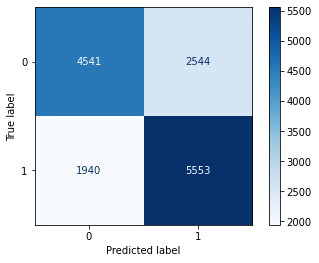

In [31]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_test, y_test, cmap='Blues') 


In [28]:
pd.concat((pd.DataFrame(df.iloc[:, 1:4].columns, columns=['variable']), 
           pd.DataFrame(rf.feature_importances_, columns=['importance'])),
        axis=1).sort_values(by='importance', ascending=False)

,variable,importance
0,radiant_adv_nw,0.465947
1,radiant_adv_xp,0.398879
2,radiant_adv_lh,0.135174
